In [1]:
import pandas as pd
import numpy as np
import os

from tqdm.notebook import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from math import ceil
from statistics import mean
#################################
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

In [2]:
def get_ref_X_y(df):
    ref_cols = [c for c in df.columns if c.startswith('__')]
    X_cols = [c for c in df.columns if c.startswith('X_')]
    y_cols = [c for c in df.columns if c.startswith('y_')]
    return (df[ref_cols], df[X_cols], df[y_cols])

In [3]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, inp, tgt, device='cpu'):
        'Initialization'
        self.inp = to_device(torch.from_numpy(inp).float(), device)
        self.tgt = to_device(torch.from_numpy(tgt).float(), device)

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.tgt)

    def __getitem__(self, index):
        'Generates one sample of data'
        return self.inp[index], self.tgt[index]

In [4]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.drop0 = torch.nn.Dropout(p=0.6)
        self.hidden1 = torch.nn.Linear(16, 100)   # hidden layer
        self.drop1 = torch.nn.Dropout(p=0.5)
        self.hidden2 = torch.nn.Linear(100, 100)   # hidden layer
        self.drop2 = torch.nn.Dropout(p=0.5)
        self.hidden3 = torch.nn.Linear(100, 100)   # hidden layer
        self.drop3 = torch.nn.Dropout(p=0.7)
        self.hidden4 = torch.nn.Linear(100, 50)   # hidden layer
        self.drop4 = torch.nn.Dropout(p=0.4)
#         self.hidden5 = torch.nn.Linear(50, 50)   # hidden layer
#         self.hidden6 = torch.nn.Linear(50, 50)   # hidden layer
#         self.hidden7 = torch.nn.Linear(50, 50)   # hidden layer
#         self.hidden8 = torch.nn.Linear(50, 50)   # hidden layer
#         self.hidden9 = torch.nn.Linear(50, 50)   # hidden layer
        self.predict = torch.nn.Linear(50, 6)   # output layer

    def forward(self, x):
        x = self.drop0(x)
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = self.drop1(x)
        x = F.relu(self.hidden2(x))      # activation function for hidden layer
        x = self.drop2(x)
        x = F.relu(self.hidden3(x))      # activation function for hidden layer
        x = self.drop3(x)
        x = F.relu(self.hidden4(x))      # activation function for hidden layer
        x = self.drop4(x)
#         x = F.relu(self.hidden5(x))      # activation function for hidden layer
#         x = F.relu(self.hidden6(x))      # activation function for hidden layer
#         x = F.relu(self.hidden7(x))      # activation function for hidden layer
#         x = F.relu(self.hidden8(x))      # activation function for hidden layer
#         x = F.relu(self.hidden9(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x
    
torch.manual_seed(0)

In [5]:
# %%time

# train_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/train.pkl")
# ref_train, X_train, y_train = get_ref_X_y(train_df)

# X_min_max_scaler = MinMaxScaler()
# y_min_max_scaler = MinMaxScaler()

# X_train = X_min_max_scaler.fit_transform(X_train)
# y_train = y_min_max_scaler.fit_transform(y_train)

# test_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/test.pkl")
# ref_test, X_test, y_test = get_ref_X_y(test_df)

# X_test = X_min_max_scaler.fit_transform(X_test)
# y_test = y_min_max_scaler.fit_transform(y_test)

In [6]:
# params = {
#     'batch_size': 250000,
# #     'shuffle': True,
#     'num_workers': 4,
# }

# training_set = Dataset(X_train, y_train)
# training_generator = torch.utils.data.DataLoader(training_set, **params)

# testing_set = Dataset(X_test, y_test)
# testing_generator = torch.utils.data.DataLoader(testing_set, **params)

In [7]:
sample_train_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/sample_train.pkl")
# sample_train_df = sample_train_df[:250000] # use partial data only

sample_ref_train, sample_X_train, sample_y_train = get_ref_X_y(sample_train_df)

sample_X_min_max_scaler = MinMaxScaler()
sample_y_min_max_scaler = MinMaxScaler()

sample_X_train = sample_X_min_max_scaler.fit_transform(sample_X_train)
sample_y_train = sample_y_min_max_scaler.fit_transform(sample_y_train)

sample_test_df = pd.read_pickle(f"{os.environ['GP_HIST_PATH']}/../3_min/sample_test.pkl")
sample_ref_test, sample_X_test, sample_y_test = get_ref_X_y(sample_test_df)

sample_X_test = sample_X_min_max_scaler.fit_transform(sample_X_test)
sample_y_test = sample_y_min_max_scaler.fit_transform(sample_y_test)

params = {
    'batch_size': 500,
    'shuffle': True,
    'num_workers': 3,
}

training_set = Dataset(sample_X_train, sample_y_train)
training_generator = torch.utils.data.DataLoader(training_set, **params)

testing_set = Dataset(sample_X_test, sample_y_test)
testing_generator = torch.utils.data.DataLoader(testing_set, **params)

In [8]:
net = Net() # define the network
print(net)  # net architecture
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

start_time = time()
num_batches = ceil(len(training_set)/params['batch_size'])
# lr=1e-4
# weight_decay=1e-5
lr=1e-5
weight_decay=1e-6
losses = []
max_epochs = 500
# train the network
do_validate = True

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

epbar = tqdm(range(max_epochs))

for epoch in epbar:
    epbar.set_description(f"Epoch {epoch+1}")

    elosses = []
    vlosses = []
    etime = time()

    ipbar = tqdm(training_generator, leave=False)
    ipbar.set_description(f"Training LR: {lr:.4f}")
    
    for i, (x, y) in enumerate(ipbar):
        itime = time()
        optimizer.zero_grad()
        prediction = net(x)     # input x and predict based on x
        loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        elosses.append(loss.data.numpy().item())
        ipbar.set_postfix({'loss': loss.data.numpy()})

    mean_vlosses = 0
    if do_validate:
        with torch.set_grad_enabled(False):
            vpbar = tqdm(testing_generator, leave=False)
            vpbar.set_description("Validating")
            for i, (x, y) in enumerate(vpbar):
                prediction = net(x)     # input x and predict based on x
                loss = loss_func(prediction, y)     # must be (1. nn output, 2. target)
                vlosses.append(loss.data.numpy().item())
                vpbar.set_postfix({'loss': loss.data.numpy()})
        mean_vlosses = mean(vlosses)
            
    mean_elosses = mean(elosses)
    losses.append((mean_elosses, mean_vlosses))
    
    epbar.set_postfix({'train_loss':f"{mean_elosses:.9f}", 'val_loss':f"{mean_vlosses:.9f}"})

Net(
  (drop0): Dropout(p=0.6, inplace=False)
  (hidden1): Linear(in_features=16, out_features=100, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (drop3): Dropout(p=0.7, inplace=False)
  (hidden4): Linear(in_features=100, out_features=50, bias=True)
  (drop4): Dropout(p=0.4, inplace=False)
  (predict): Linear(in_features=50, out_features=6, bias=True)
)


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

  0%|          | 0/5640 [00:00<?, ?it/s]

  0%|          | 0/389 [00:00<?, ?it/s]

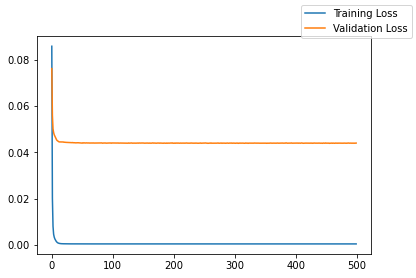

In [11]:
tl, vl = zip(*losses)

fig,ax = plt.subplots()
ax.plot(tl, label="Training Loss")
ax.plot(vl, label="Validation Loss")

fig.legend()
plt.show()

In [10]:
torch.save(net,"sample_training_model_v2.pt")